## Project 

In [1]:
import torch 
import numpy as np

np.random.seed(1328)
torch.random.manual_seed(1328)

In [2]:
import os
import cv2
from tqdm import tqdm
import shutil

def capture_frames(video_name, output_folder, num_frames_to_capture=1000):
    # Extract the filename without extension
    video_name_without_extension = os.path.splitext(os.path.basename(video_name))[0]
    video = cv2.VideoCapture(video_name)
    
    # Read a frame to get video information
    ret, _ = video.read()
    if not ret:
        print(f"Error: unable to open the video {video_name}.")
        return 0, 0
    
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_captured = 0

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Determine the actual number of frames to capture
    step_size = max(total_frames // num_frames_to_capture, 1)
    tqdm_total = min(num_frames_to_capture, total_frames)
    
    # Initialize the progress bar
    with tqdm(total=tqdm_total, desc=f'Processing {video_name}', unit='frame') as progress_bar:
        for i in range(0, total_frames, step_size):
            video.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = video.read()
            if not ret:
                break
            
            # Frame processing and saving
            frame = cv2.resize(frame, (224, 224))
            frame_path = os.path.join(output_folder, f"frame_{frames_captured + 1}.png")
            cv2.imwrite(frame_path, frame)
            frames_captured += 1
            
            # Update the progress bar
            progress_bar.update(1)  

    print(f"Processing completed for {video_name}.")
    video.release()
    return frames_captured, total_frames


def process_videos_in_folder(folder_path, num_frames_to_capture=1000):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mp4'):
            file_path = os.path.join(folder_path, file_name)
            output_folder = os.path.join(os.path.dirname(folder_path), f"{os.path.splitext(file_name)[0]}_frames")
            captured, total = capture_frames(file_path, output_folder, num_frames_to_capture)
            print(f'Extracted {captured}/{total} frames from {file_name}')

In [3]:
def reorganize_frames(data_dir):
    categories = ['rock', 'paper', 'scissors']
    
    for category in categories:
        output_folder = os.path.join(data_dir, f"{category}_frames")
        
        # Collect all frames for each category
        for dir_name in os.listdir(data_dir):
            if dir_name.startswith(category):
                src_folder = os.path.join(data_dir, dir_name)
                for frame_name in os.listdir(src_folder):
                    src_path = os.path.join(src_folder, frame_name)
                    dest_path = os.path.join(output_folder, frame_name)
                    shutil.move(src_path, dest_path)
                    
    print("Reorganization completed.")

In [4]:
data_dir = ['data/train', 'data/test']

# Reorganize frames
for dir_path in data_dir:
    reorganize_frames(dir_path)

Reorganization completed.
Reorganization completed.


In [5]:
import pandas as pd

train_images = []
train_labels = []
test_images = []
test_labels = []

for dir_path in data_dir:    
    for subfolder in os.listdir(dir_path):
        subfolder_path = os.path.join(dir_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        if subfolder.endswith('_frames'):
            label = subfolder.replace('_frames', '')
            for image_filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_filename)
                if dir_path == 'data/train':
                    train_images.append(image_path)
                    train_labels.append(label)
                else:
                    test_images.append(image_path)
                    test_labels.append(label)

df_train = pd.DataFrame({'image': train_images, 'label': train_labels})
df_test = pd.DataFrame({'image': test_images, 'label': test_labels})

print(f"Training DataFrame Description:\n{df_train.describe()}\nTraining DataFrame:\n{df_train.sample(5)}")
print('-' * 60)
print(f"Testing DataFrame Description:\n{df_test.describe()}\nTesting DataFrame:\n{df_test.sample(5)}\n")

Training DataFrame Description:
                                         image     label
count                                    14616     14616
unique                                   14616         3
top     data/train/paper_frames/frame_1429.png  scissors
freq                                         1      5090
Training DataFrame:
                                          image     label
2447   data/train/scissors_frames/frame_560.png  scissors
14247    data/train/paper_frames/frame_4571.png     paper
11605    data/train/paper_frames/frame_1384.png     paper
12524    data/train/paper_frames/frame_3698.png     paper
5902      data/train/rock_frames/frame_3762.png      rock
------------------------------------------------------------
Testing DataFrame Description:
                                       image     label
count                                   1500      1500
unique                                  1500         3
top     data/test/paper_frames/frame_389.png  scissors
fre

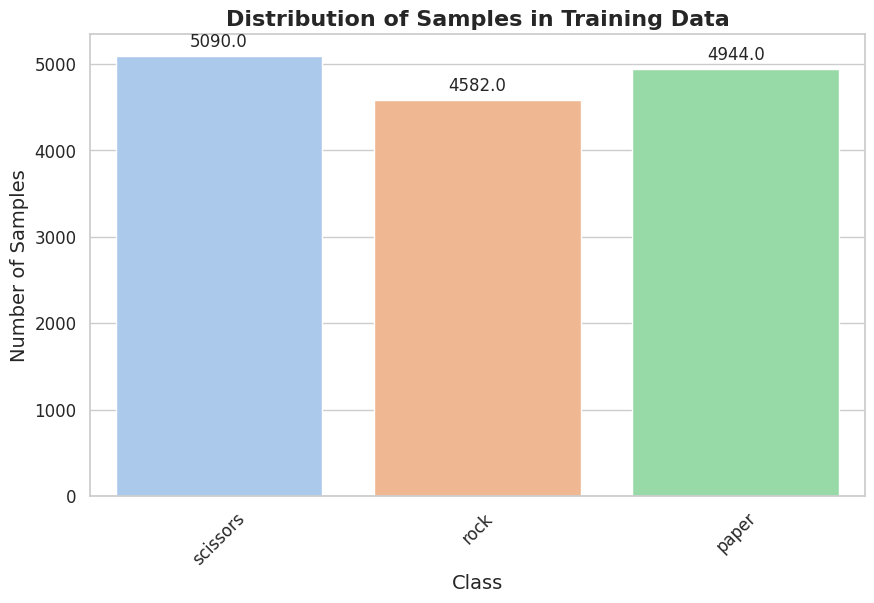

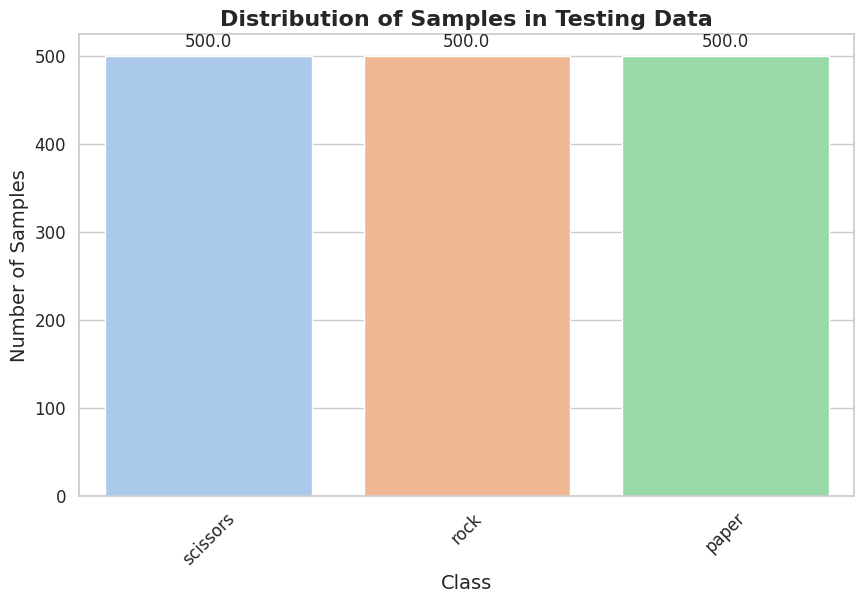

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df.label, hue=df.label, palette="pastel", dodge=False)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/{title}.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

plot_class_distribution(df_train, "Distribution of Samples in Training Data")
plot_class_distribution(df_test, "Distribution of Samples in Testing Data")

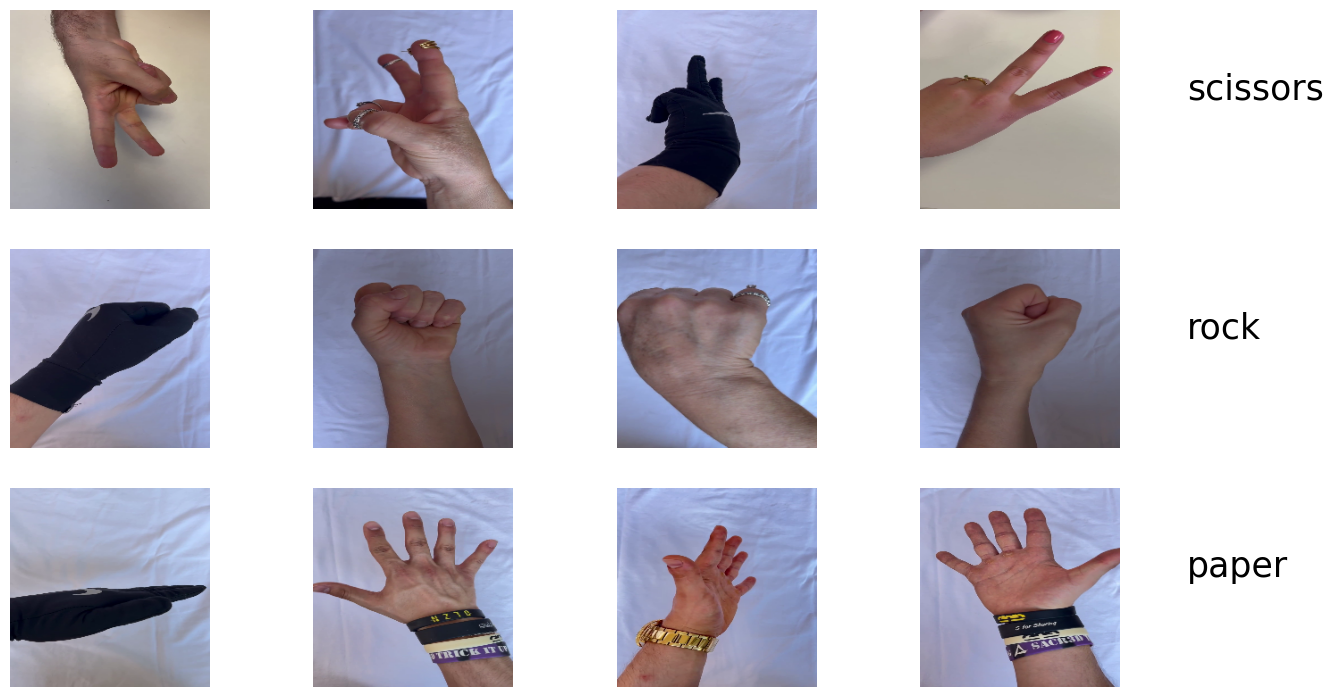

In [7]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

for i, category in enumerate(df_train['label'].unique()):
    filepaths = df_train[df_train['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=25, color='black')
plt.show()

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.dataframe['label'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label_str = self.dataframe.iloc[idx, 1]
        label = self.class_to_idx[label_str]  
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CustomDataset(df_train, transform=train_transform)
test_dataset = CustomDataset(df_test, transform=val_transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join

class RPSClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=3):
        super(RPSClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

    def train_model(self, train_loader, test_loader, exp_name='experiment', lr=0.001, epochs=10, m=0.9, logdir='logs', offset=0):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=m)  
    
        train_losses = []; train_accuracies = []
        test_losses = []; test_accuracies = []
    
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(device)
        loader = {'train' : train_loader, 'test' : test_loader }
    
        global_step = 0
        for e in range(epochs):
            print(f'[Epoch {e+1+offset}/{epochs+offset}]')
            for mode in ['train', 'test']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()
    
                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)
    
                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)
    
                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()
    
                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)
    
                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
    
                writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
                writer.add_scalar('accuracy/'+mode, acc_meter.value(), global_step=global_step)
    
                if mode == 'train':
                    train_losses.append(loss_meter.value())
                    train_accuracies.append(acc_meter.value())
                else:
                    test_losses.append(loss_meter.value())
                    test_accuracies.append(acc_meter.value())
                    
            print(f'[Epoch {e+1+offset}/{epochs+offset}] - Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Accuracy: {test_accuracies[-1]:.3f}\n')
            torch.save(self.model.state_dict(), f'models/{exp_name}-{e+1}.pth')

        return train_losses, train_accuracies, test_losses, test_accuracies

    def test_classifier(self, loader):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(device)
        predictions, labels = [], []
        with torch.no_grad():
            for batch in loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        return np.array(predictions), np.array(labels)

    def perc_error(self, gt, pred):
        return (1 - accuracy_score(gt, pred)) * 100

In [11]:
rps_classifier = RPSClassifier()

e = 45
offset = 0
train_losses, train_accuracies, test_losses, test_accuracies = rps_classifier.train_model(train_loader, 
                                                                                          test_loader, 
                                                                                          exp_name='rps_experiment', 
                                                                                          epochs=e,
                                                                                          offset=offset)

[Epoch 1/45]
[Epoch 1/45] - Train Loss: 1.097, Train Accuracy: 0.354, Test Loss: 1.100, Test Accuracy: 0.333

[Epoch 2/45]
[Epoch 2/45] - Train Loss: 1.095, Train Accuracy: 0.362, Test Loss: 1.100, Test Accuracy: 0.333

[Epoch 3/45]
[Epoch 3/45] - Train Loss: 1.092, Train Accuracy: 0.381, Test Loss: 1.099, Test Accuracy: 0.333

[Epoch 4/45]
[Epoch 4/45] - Train Loss: 1.085, Train Accuracy: 0.413, Test Loss: 1.098, Test Accuracy: 0.440

[Epoch 5/45]
[Epoch 5/45] - Train Loss: 1.075, Train Accuracy: 0.429, Test Loss: 1.084, Test Accuracy: 0.435

[Epoch 6/45]
[Epoch 6/45] - Train Loss: 1.053, Train Accuracy: 0.449, Test Loss: 1.053, Test Accuracy: 0.467

[Epoch 7/45]
[Epoch 7/45] - Train Loss: 1.003, Train Accuracy: 0.500, Test Loss: 0.984, Test Accuracy: 0.519

[Epoch 8/45]
[Epoch 8/45] - Train Loss: 0.917, Train Accuracy: 0.571, Test Loss: 0.865, Test Accuracy: 0.603

[Epoch 9/45]
[Epoch 9/45] - Train Loss: 0.794, Train Accuracy: 0.639, Test Loss: 0.747, Test Accuracy: 0.653

[Epoch 10/

In [12]:
import pickle

# Save model
model = f'models/rps_experiment-{e+offset}.pth'
torch.save(rps_classifier.state_dict(), model) 
print('Model saved successfully')

# Save data
with open('rps_experiment_metrics.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }, f)
    
print('Data saved successfully')

Model saved successfully
Data saved successfully


In [13]:
rps_classifier = RPSClassifier()

# Load model
rps_classifier.load_state_dict(torch.load(model)) 
print('Model loaded successfully')

# Load data
with open('rps_experiment_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
print('Data loaded successfully')

train_losses = metrics['train_losses']
train_accuracies = metrics['train_accuracies']
test_losses = metrics['test_losses']
test_accuracies = metrics['test_accuracies']

Model loaded successfully
Data loaded successfully


In [14]:
# Continue the train
e = 5
offset = len(train_losses)
train_losses_, train_accuracies_, test_losses_, test_accuracies_ = rps_classifier.train_model(
    train_loader, 
    test_loader, 
    exp_name='rps_experiment', 
    epochs=e, 
    offset=offset
)

# Save model and data
torch.save(rps_classifier.state_dict(), 'models/rps_experiment-50.pth') 

train_losses.extend(train_losses_)
train_accuracies.extend(train_accuracies_)
test_losses.extend(test_losses_)
test_accuracies.extend(test_accuracies_)

with open('rps_experiment_metrics.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }, f)

[Epoch 46/50]
[Epoch 46/50] - Train Loss: 0.030, Train Accuracy: 0.990, Test Loss: 0.328, Test Accuracy: 0.871

[Epoch 47/50]
[Epoch 47/50] - Train Loss: 0.025, Train Accuracy: 0.993, Test Loss: 0.515, Test Accuracy: 0.801

[Epoch 48/50]
[Epoch 48/50] - Train Loss: 0.018, Train Accuracy: 0.995, Test Loss: 0.517, Test Accuracy: 0.851

[Epoch 49/50]
[Epoch 49/50] - Train Loss: 0.018, Train Accuracy: 0.994, Test Loss: 0.411, Test Accuracy: 0.846

[Epoch 50/50]
[Epoch 50/50] - Train Loss: 0.012, Train Accuracy: 0.997, Test Loss: 0.403, Test Accuracy: 0.801



In [15]:
test_predictions, test_labels = rps_classifier.test_classifier(test_loader)
error = rps_classifier.perc_error(test_labels, test_predictions)
print(f"Error percentage : {error:.2f} %")

Error percentage : 19.93 %


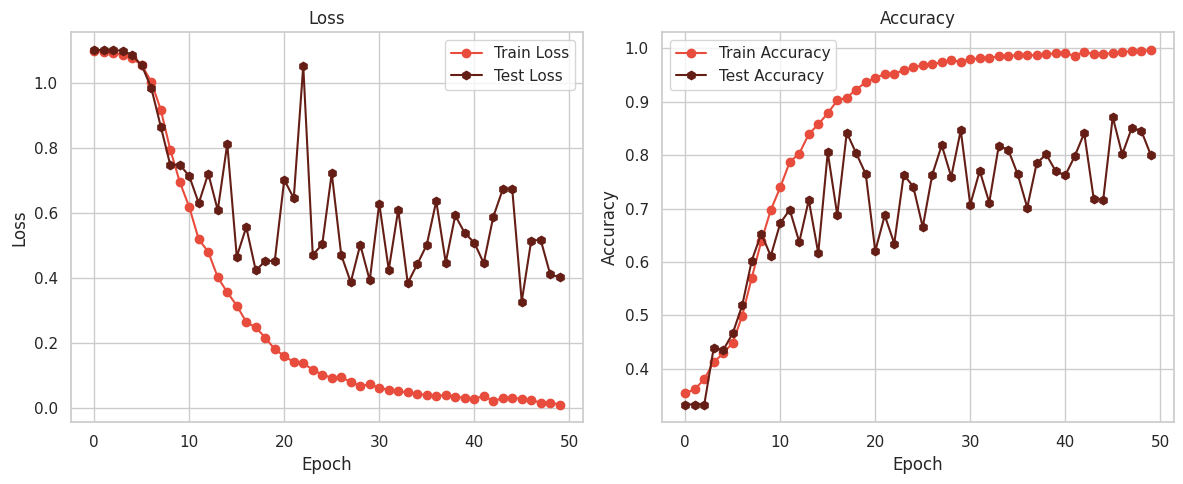

In [24]:
def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(test_losses, color="#641E15", label='Test Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, color="#641E15", label='Test Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, 'plots/Accuracy_and_Loss.png')

In [52]:
def evaluate_model(model, test_loader, device, epochs):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    test_losses = []
    test_accuracies = []

    with torch.no_grad():
        for _ in range(epochs):
            epoch_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                epoch_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)
            
            test_losses.append(epoch_loss / len(test_loader))
            test_accuracies.append(correct_predictions / total_predictions)

    return test_losses, test_accuracies

In [43]:
def plot_comparison(model_name, rps_test_losses, rps_test_accuracies, model_test_losses, model_test_accuracies, save_path):
    epochs = range(1, len(rps_test_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, rps_test_losses, color="#641E15", label='RPS Test Loss', marker='o')
    plt.plot(epochs, model_test_losses, color="#3498DB", label=f'{model_name} Test Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Test Loss Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rps_test_accuracies, color="#641E15", label='RPS Test Accuracy', marker='o')
    plt.plot(epochs, model_test_accuracies, color="#3498DB", label=f'{model_name} Test Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Test Accuracy Comparison')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

## Confronto con ResNet e VGG

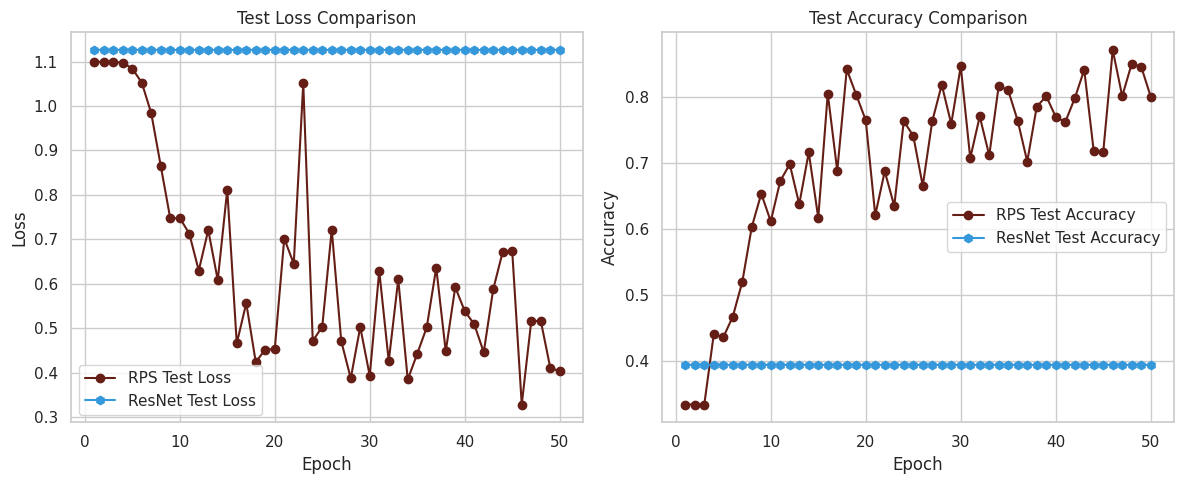

In [53]:
# Load ResNet 
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)  

device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = resnet.to(device)

rps_test_losses = test_losses
rps_test_accuracies = test_accuracies

# Create DataLoader
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet_test_dataset = CustomDataset(df_test, transform=resnet_transform)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=64, shuffle=False)

# Evaluate ResNet and Plot comparison
resnet_test_losses, resnet_test_accuracies = evaluate_model(resnet, resnet_test_loader, device, epochs=len(rps_test_losses))
plot_comparison('ResNet', rps_test_losses, rps_test_accuracies, resnet_test_losses, resnet_test_accuracies,'plots/Comparison_RPS_ResNet_Test_Performance.png')

In [ ]:
# Load VGG 
vgg = models.vgg16(weights=models.VGG16Weights.IMAGENET1K_V1)
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg = vgg.to(device)

# Create DataLoader for VGG test set
vgg_test_dataset = CustomDataset(df_test, transform=resnet_transform) # use the same of ResNet
vgg_test_loader = DataLoader(vgg_test_dataset, batch_size=64, shuffle=False)

# Evaluate VGG and Plot comparison
vgg_test_losses, vgg_test_accuracies = evaluate_model(vgg, vgg_test_loader, device, epochs=len(rps_test_losses))
plot_comparison('VGG', rps_test_losses, rps_test_accuracies, vgg_test_losses, vgg_test_accuracies, 'plots/Comparison_RPS_VGG_Test_Performance.png')